Copyright © 2022 Gurobi Optimization, LLC

# 多少钱合适? 使用数学优化进行牛油果定价和供应

2017年3月的一篇[Food Network文章](https://www.foodnetwork.com/fn-dish/news/2018/3/avocado-unseats-banana-as-america-s-top-fruit-import-by-value)宣称,"牛油果取代香蕉成为美国进口水果第一名。"这个说法不够完整且存在争议,原因不仅仅在于牛油果是否属于水果。牛油果价格昂贵。

作为供应商,设定合适的牛油果价格需要权衡。
价格太高会失去客户。价格太低则无法盈利。
有了好的数据支持,牛油果的定价和供应问题为展示优化和数据科学的力量提供了很好的机会。

俗话说,生活给了你牛油果,就做成鳄梨酱。
就像完美的鳄梨酱需要适量的洋葱、柠檬和香料,找到最佳的牛油果价格需要描述性、预测性和规范性分析的恰当组合。

|<img src="avocado_image_grocery.jpeg" width="500" align="center">| 
|:--:|
| <b>牛油果:杂货店的必备区。图片来源:[New York Post](https://nypost.com/2022/02/15/us-will-halt-mexico-avocado-imports-as-long-as-necessary/) </b>| 


**目标**: 开发一个数据科学流程来为牛油果定价和分销以实现收入最大化。

这个笔记本将引导完成一个以数学优化模型为结果的决策流程。
分为三个阶段:
- 首先,了解数据集并推断销售量、价格、地区和季节性趋势等类别之间的关系。
- 其次,建立一个预测模型,根据价格、地区、年份和季节性来预测牛油果的需求。
- 第三,设计一个优化问题,在考虑浪费和运输成本的同时,设定最佳价格和供应量以实现净收入最大化。


## 加载包和数据集

我们使用[Hass牛油果协会](https://hassavocadoboard.com/)(HAB)提供的真实销售数据,该协会的目标是"让牛油果成为美国最受欢迎的水果"。该数据集包含了多年来牛油果市场价格和销售的综合信息。

我们现在将加载以下包来分析和可视化数据。

In [ ]:
# %pip install gurobipy

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn import tree 
import seaborn as sns
import sklearn 
import numpy as np  

HAB的数据集包含2019-2022年的销售数据。此数据通过[Kaggle](https://www.kaggle.com/datasets/timmate/avocado-prices-2020)上HAB的早期下载数据(2015-2018年销售数据)进行了补充。

数据集中的每一行是按地区和牛油果类型分类的每周牛油果销售数量和每周平均价格。有两种类型的牛油果:传统和有机。在本笔记本中,我们将只考虑传统牛油果。
有八个大区域,即五大湖区、中南部、东北部、北新英格兰、南中部、东南部、西部和平原区。

现在,让我们加载数据并存储到Pandas数据框中。

In [2]:
# avocado = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/price_optimization/HABdata_2019_2022.csv') # dataset downloaded directly from HAB
avocado = pd.read_csv('HABdata_2019_2022.csv') # dataset downloaded directly from HAB
# avocado_old = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/price_optimization/kaggledata_till2018.csv') # dataset downloaded from Kaggle
avocado_old = pd.read_csv('kaggledata_till2018.csv') # dataset downloaded from Kaggle
avocado = pd.concat([avocado, avocado_old], ignore_index=True)
avocado

,region,date,type,price,units_sold
0,Great_Lakes,1/7/19 0:00,Conventional,1.106743,3812441.96
1,Great_Lakes,1/7/19 0:00,Organic,1.371280,275987.52
2,Great_Lakes,1/13/19 0:00,Conventional,1.063457,3843318.68
3,Great_Lakes,1/13/19 0:00,Organic,1.493384,244991.95
4,Great_Lakes,1/20/19 0:00,Conventional,1.049931,4587957.69
...,...,...,...,...,...
6799,West,11/18/18,Organic,1.610000,334096.14
6800,West,11/25/18,Conventional,1.240000,3260102.17
6801,West,11/25/18,Organic,1.730000,268362.34
6802,West,12/2/18,Conventional,1.200000,4594863.86


## 准备数据集

我们现在将准备数据用于销售预测。为数据框添加年份和季节性的新列。让2015年至2022年的每一年按年份递增顺序分别赋予0到7的索引。我们将2月到7月定义为旺季。这些月份是根据趋势的可视化检查来设定的,但你可以尝试设置其他月份。

In [3]:
# 为2015年至2022年的每一年添加索引
avocado['date'] = pd.to_datetime(avocado['date'])
avocado['year'] = pd.DatetimeIndex(avocado['date']).year
avocado['year_index'] = avocado['year'] - 2015
avocado = avocado.sort_values(by='date')

# 定义旺季
avocado['month'] = pd.DatetimeIndex(avocado['date']).month
peak_months = range(2,8)        # <--------- 设置"旺季"的月份
def peak_season(row):
    return 1 if int(row['month']) in peak_months else 0  

avocado['peak'] = avocado.apply(lambda row: peak_season(row), axis=1)

# 将牛油果数量缩放为百万
avocado['units_sold'] = avocado['units_sold']/1000000

# 只选择传统牛油果
avocado = avocado[avocado['type'] == 'Conventional'] 

avocado = avocado[['date','units_sold','price','region','year','month','year_index','peak']].reset_index(drop = True)

avocado

,date,units_sold,price,region,year,month,year_index,peak
0,2015-01-04,3.382800,1.020000,Great_Lakes,2015,1,0,0
1,2015-01-04,2.578275,1.100000,Midsouth,2015,1,0,0
2,2015-01-04,5.794411,0.890000,West,2015,1,0,0
3,2015-01-04,3.204112,0.980000,Southeast,2015,1,0,0
4,2015-01-04,0.321824,1.050000,Northern_New_England,2015,1,0,0
...,...,...,...,...,...,...,...,...
3397,2022-05-15,4.150433,1.269883,SouthCentral,2022,5,7,1
3398,2022-05-15,4.668815,1.644873,Northeast,2022,5,7,1
3399,2022-05-15,32.745321,1.527357,Total_US,2022,5,7,1
3400,2022-05-15,3.542902,1.514583,Midsouth,2022,5,7,1


## 第一部分: 观察数据趋势

现在,我们将推断时间和季节性的销售趋势。为简单起见,让我们使用整个美国的数据进行分析。

In [4]:
df_Total_US = avocado[avocado['region']=='Total_US']

### 逐年销售情况

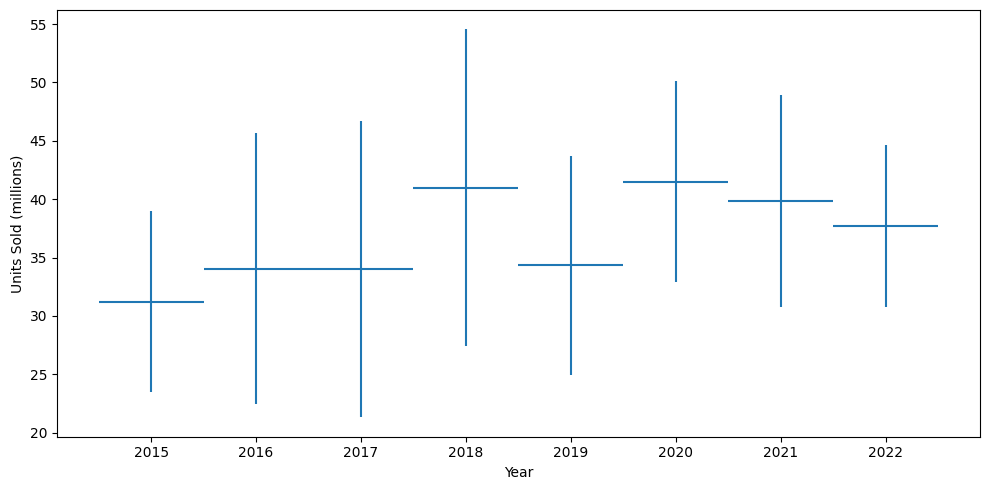

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5)) 

mean = df_Total_US.groupby('year')['units_sold'].mean()
std  = df_Total_US.groupby('year')['units_sold'].std()
axes.errorbar(mean.index, mean, xerr=0.5, yerr=2*std, linestyle='') 
axes.set_ylabel('Units Sold (millions)')
axes.set_xlabel('Year') 
 
fig.tight_layout()

我们可以看到,多年来销售量总体上有所增长,尽管增幅不大。2019年的下降是由于广为记载的[2019年牛油果短缺](https://abc7news.com/avocado-shortage-season-prices/5389855/)导致,使得牛油果价格[几乎翻了一倍](https://abc7news.com/avocado-shortage-season-prices/5389855/)。

### 季节性

我们现在来看看一年内的销售趋势。

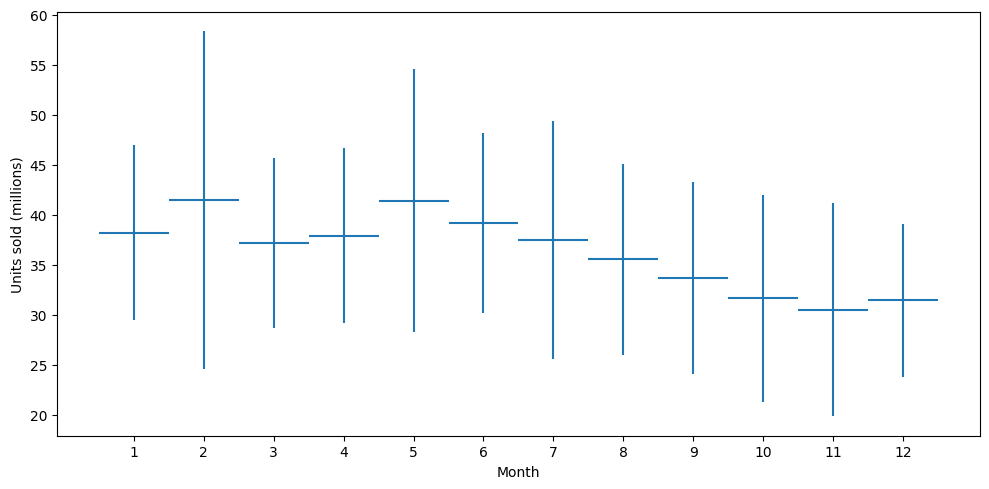

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5)) 

mean = df_Total_US.groupby('month')['units_sold'].mean()
std  = df_Total_US.groupby('month')['units_sold'].std()
 
axes.errorbar(mean.index, mean, xerr=0.5, yerr=2*std, linestyle='') 
axes.set_ylabel('Units Sold (millions)')
axes.set_xlabel('Month') 
 
fig.tight_layout()
 
plt.xlabel('Month')
axes.set_xticks(range(1,13)) 
plt.ylabel('Units sold (millions)')
plt.show()

我们可以看到2月超级碗和5月五月五日节期间的销售高峰。

### 相关性分析

现在,我们将看看变量之间的相关性。
最终目标是根据牛油果价格、年份和季节性(是否为旺季)来预测销量。

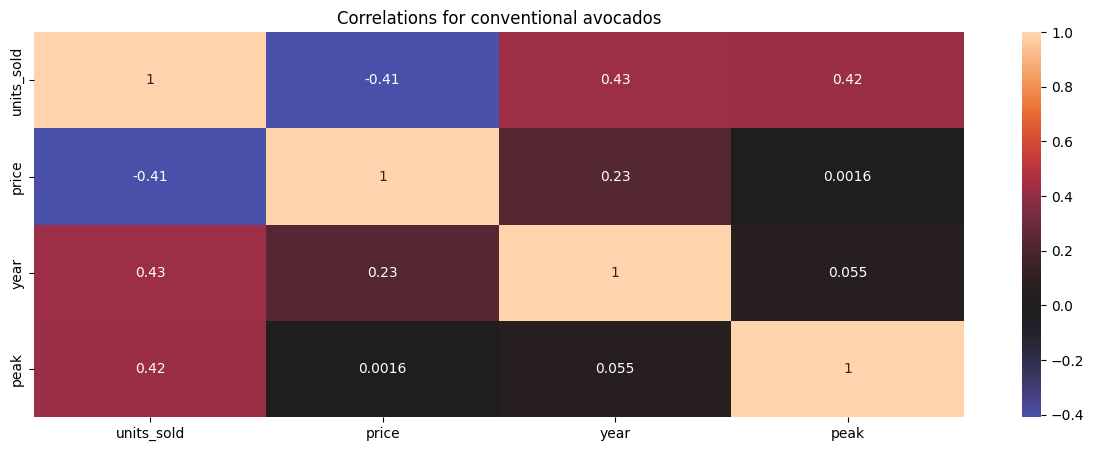

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5)) 
sns.heatmap(df_Total_US[['units_sold', 'price', 'year', 'peak']].corr(),annot=True, center=0,ax=axes) 

axes.set_title('Correlations for conventional avocados') 
plt.show()

正如预期,销售数量与每个牛油果的价格呈负相关。销售数量与年份以及是否处于旺季呈正相关。

### 区域分析

最后,我们将看看不同地区之间的销售差异。这将决定我们要向每个地区供应的牛油果数量。

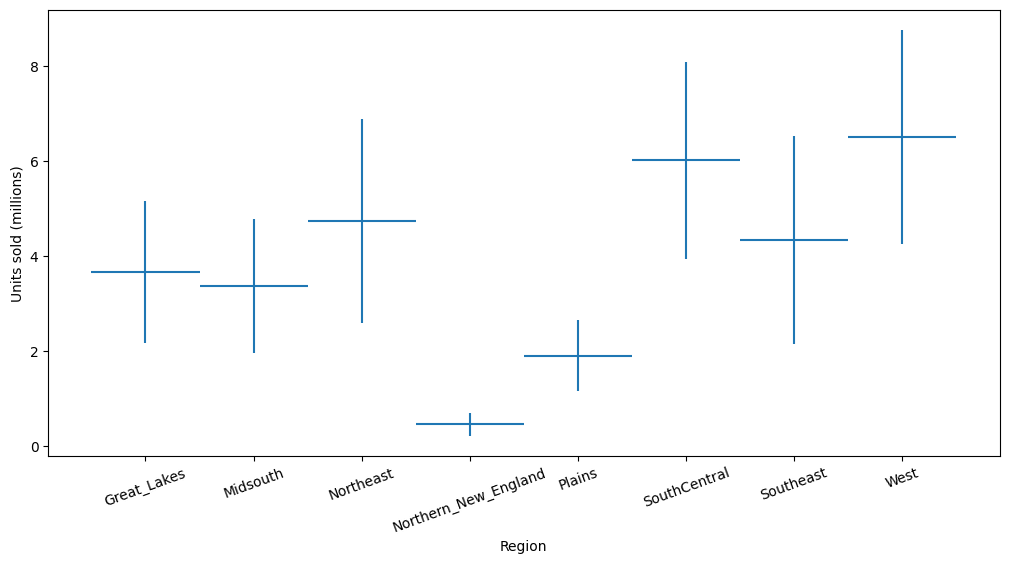

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5)) 

regions = ['Great_Lakes','Midsouth','Northeast','Northern_New_England','SouthCentral','Southeast','West','Plains'] 
df = avocado[avocado.region.isin(regions)]  

mean = df.groupby('region')['units_sold'].mean()
std  = df.groupby('region')['units_sold'].std() 
 
axes.errorbar(range(len(mean)), mean, xerr=0.5, yerr=2*std, linestyle='')  

fig.tight_layout()
 
plt.xlabel('Region') 
plt.xticks(range(len(mean)), pd.DataFrame(mean)['units_sold'].index,rotation=20)
plt.ylabel('Units sold (millions)')
plt.show()

显然,西海岸人更喜欢牛油果。

## 第二部分: 预测销量

第一部分观察到的趋势促使我们使用自变量(价格、年份、地区和季节性)构建销售预测模型。
从此开始,销售数量将被称为*预测需求*。

让我们现在为需求构建一个线性回归模型。
注意地区是一个分类变量。
线性回归可以用数学表达式表示为:

$$demand = \beta_0 + \beta_1 * price + \sum\limits_{region} \beta^{region}_3 * \mathbb{1}(region)  +  \beta_4 w_{year}*year +  \beta_5  * \mathbb{1}(peak).$$

这里,$\beta$值是需要从数据中学习的权重(或"系数")。
注意,$\mathbb{1}(region)$表示法是一个指示函数,在求和中对每个地区取值为$1$。如果我们考虑旺季,$\mathbb{1}(peak)$的值为$1$。

为验证回归模型,我们将数据集随机分为$80\%$的训练数据和$20\%$的测试数据,并使用scikit-learn来学习权重。

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# 将数据分为训练集和测试集
train, test = train_test_split(df, train_size=0.8, random_state=1)
df_train = pd.DataFrame(train, columns=df.columns)
df_test = pd.DataFrame(test, columns=df.columns)
 
# 训练模型
formula = 'units_sold ~ price + year_index + C(region)+ peak'
mod = smf.ols(formula,data=df_train)
result = mod.fit()
result.summary()

# 从测试数据获取R^2值
y_true = df_test['units_sold']
y_pred = result.predict(df_test)
print("测试集中的R^2值为",r2_score(y_true, y_pred))

测试集中的R^2值为 0.8982069358257863


我们可以观察到测试集中的$R^2$值良好。我们现在将拟合权重到完整数据集。

In [ ]:
formula = 'units_sold ~ price + year_index + C(region)+ peak'
mod_full = smf.ols(formula,data=df)
result_full = mod_full.fit()

y_true_full = df['units_sold']
y_pred_full = result_full.predict(df)
print("The R^2 value in the full dataset is",r2_score(y_true_full, y_pred_full))

# 获取权重，并存起来
coef_dict = result_full.params.to_dict() 
coef_dict['C(region)[T.Great_Lakes]'] = 0 

The R^2 value in the full dataset is 0.9066729322212482


## 第三部分: 优化牛油果的价格和供应

知道牛油果的价格如何影响需求,我们如何设定最佳的牛油果价格?
我们不想把价格定得太高,因为那样会降低需求和销售量。同时,把价格定得太低在最大化收入时可能不是最优的。那么,最佳价格是多少呢?

在分销物流方面,我们要确保各个地区有足够的牛油果。我们可以在数学优化模型中解决这些问题。
优化模型根据**目标函数**找到**最佳解决方案**,使得解决方案满足一组**约束条件**。
在这里,解决方案表示为一个实数或整数的向量,称为**决策变量**。
约束条件是一组以决策变量为函数的方程或不等式。

在每周开始时,假设可用的总产品数量是有限的。这个数量需要分配到各个地区,同时最大化净收入。因此,有两个关键决策 - 每个地区的牛油果价格和分配到每个地区的牛油果数量。

现在,让我们定义一些用于创建模型的输入参数和符号。下标$r$将用于表示每个地区。

### 输入参数
- $R$: 地区集合,
- $d(p,r)$: 当牛油果每个产品的价格为$p$时,地区$r\in R$的预测需求,
- $B$: 可分配到各个地区的牛油果总量,
- $c_{waste}$: 每个浪费的牛油果的成本($\$$),
- $c^r_{transport}$: 运输到地区$r \in R$的牛油果的成本($\$$),
- $a^r_{min},a^r_{max}$: 地区$r \in R$的每个牛油果的最低和最高价格($\$$),
- $b^r_{min},b^r_{max}$: 分配到地区$r \in R$的牛油果的最小和最大数量,

以下代码加载Gurobi python包并初始化优化模型。
$B$的值设为3000万个牛油果,接近数据中的平均每周供应量。
为了说明,让我们考虑2021年的旺季。
浪费一个牛油果的成本设为$0.10$。
运输一个牛油果的成本根据每个地区距离南部边界的远近在$0.10$到$0.50$之间变化,大部分牛油果供应来自[南部边界](https://www.britannica.com/plant/avocado)。
此外,我们可以设定牛油果的价格不超过每个$2$。

In [11]:
import gurobipy as gp 
from gurobipy import GRB

m = gp.Model("Avocado_Price_Allocation")

# 集合和参数
R = regions   # 所有地区的集合

B = 30  # 牛油果总供应量

peak_or_not = 1 # 1表示旺季; 0表示非旺季
year = 2022

c_waste = 0.1 # 浪费一个牛油果的成本($)
c_transport = {'Great_Lakes': .3,'Midsouth':.1,'Northeast':.4,'Northern_New_England':.5,'SouthCentral':.3,'Southeast':.2,'West':.2,'Plains':.2}
# 运输一个牛油果的成本

# 从数据集获取价格和存货数量的上下界
a_min = {r: 0 for r in R} # 每个地区的最低牛油果价格
a_max = {r: 2 for r in R} # 每个地区的最高牛油果价格
b_min = dict(df.groupby('region')['units_sold'].min())  # 分配给每个地区的牛油果最小数量
b_max = dict(df.groupby('region')['units_sold'].max())   # 分配给每个地区的牛油果最大数量

Set parameter LicenseID to value 2601452


### 决策变量

现在,让我们定义决策变量。
在我们的模型中,我们希望存储每个地区的价格和分配的牛油果数量。我们还希望有变量来跟踪每个地区预测的销售数量和浪费的数量。
以下符号用于建模这些决策变量,每个地区$r$索引。

$p_r$: 地区$r$的牛油果价格($\$$),

$x_r$: 分配到地区$r$的牛油果数量,

$s_r = \min \{x_r,d_r(p_r)\}$: 地区$r$预测的牛油果销售数量,

$w_r = x_r - s_r$: 地区$r$预测的牛油果浪费数量

我们现在将这些变量添加到Gurobi模型中。

In [16]:
p = m.addVars(R,name="p",lb=a_min, ub=a_max)   # 每个地区的牛油果价格
x = m.addVars(R,name="x",lb=b_min,ub=b_max)  # 分配给每个地区的数量
s = m.addVars(R,name="s",lb=0)   # 给定价格下每个地区的预测销售量
w = m.addVars(R,name="w",lb=0)   # 每个地区的过剩浪费

现在,让我们创建一个表达式,表示每个地区的预测需求作为价格的函数。注意,除了价格之外,预测函数中的其他参数(如地区、年份和季节性)都不是决策变量,因此可以视为常量。

In [17]:
d = {r: (coef_dict['Intercept']+coef_dict['price']*p[r] + coef_dict['C(region)[T.%s]'%r] + coef_dict['year_index']*(year-2015) + coef_dict['peak']*peak_or_not) for r in R}
for r in R:
    print(d[r])

7.113205674224997 + -2.2037701048902503 <gurobi.Var *Awaiting Model Update*>
6.870512520547117 + -2.2037701048902503 <gurobi.Var *Awaiting Model Update*>
8.546225510868231 + -2.2037701048902503 <gurobi.Var *Awaiting Model Update*>
4.093961883587106 + -2.2037701048902503 <gurobi.Var *Awaiting Model Update*>
8.827017748198465 + -2.2037701048902503 <gurobi.Var *Awaiting Model Update*>
7.697195840886165 + -2.2037701048902503 <gurobi.Var *Awaiting Model Update*>
9.715005122866264 + -2.2037701048902503 <gurobi.Var *Awaiting Model Update*>
5.298172801834592 + -2.2037701048902503 <gurobi.Var *Awaiting Model Update*>


### 设置目标

接下来,我们将定义目标函数:我们希望最大化**净收入**。每个地区的销售收入由该地区的牛油果价格乘以销售数量计算。产生的成本有两种:未售出牛油果的浪费成本和将牛油果运输到不同地区的成本。

净收入是销售收入减去总成本。我们假设采购成本是固定的,不包含在此模型中。

使用定义的决策变量,目标可以写成如下。

\begin{align}
\textrm{maximize} &  \sum_{r}  (p_r * s_r - c_{waste} * w_r - c^r_{transport} * x_r)& 
\end{align}

现在,让我们将目标函数添加到模型中。

In [18]:
m.setObjective(sum(p[r]*s[r] - c_waste*w[r] - c_transport[r]*x[r] for r in R)) 
m.ModelSense = GRB.MAXIMIZE

### 添加供应约束

我们现在引入约束条件。第一个约束是确保分配的牛油果总数等于$B$,可以用数学表达式表示如下。

\begin{align*} 
\sum_{r} x_r &= B
\end{align*}

以下代码将此约束添加到模型中。

In [19]:
m.addConstr(sum(x[r] for r in R) == B)
m.update()

### 添加定义销售数量的约束

接下来,我们应该定义每个地区的预测销售数量。
我们可以假设如果供应量超过预测需求,我们销售的数量正好等于预测需求。
否则,我们销售的数量正好等于分配量。
因此,预测销售数量是供应量和预测需求的最小值,即$s_r = \min \{x_r,d_r(p_r)\}$。
这种关系可以通过以下两个约束条件来建模,每个地区$r$。

\begin{align*} 
s_r &\leq x_r  \\
s_r &\leq d(p_r,r)  
\end{align*}

这些约束将确保地区$r$的销售数量$s_r$既不大于分配量也不大于预测需求。注意,最大化目标函数试图最大化销售收入,因此优化器将最大化预测销售数量。这是假设浪费和运输成本小于每个牛油果的销售价格。因此,这些约束和目标将确保销售等于供应量和预测需求的最小值。

现在,让我们将这些约束添加到模型中。

In [20]:
m.addConstrs((s[r] <= x[r] for r in R))
m.addConstrs((s[r] <= d[r] for r in R)) 
m.update()

### 添加浪费约束

最后,我们应该定义每个地区的预测浪费,由未预测销售的供应量给出。我们可以用数学表达式表示每个地区$r$。

\begin{align*} 
w_r &= x_r - s_r
\end{align*} 

我们可以将这些约束添加到模型中。

In [21]:
m.addConstrs((w[r] == x[r]-s[r] for r in R))
m.update()

### 启动求解器

我们已经将决策变量、目标函数和约束条件添加到模型中。
模型已准备好求解。
在此之前,我们应该让求解器知道这是哪种类型的模型。
默认设置假设目标和约束是变量的线性函数。

在我们的模型中,目标是**二次的**,因为我们取价格和预测销售的乘积,这两个都是变量。
最大化二次项被称为**非凸**,我们通过将Gurobi参数值设为$2$来指定这一点。
详情请参见[这里](https://www.gurobi.com/documentation/9.5/refman/nonconvex.html)。

In [22]:
m.Params.NonConvex = 2 
m.optimize() 

Set parameter NonConvex to value 2
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) Ultra 5 125H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 18 logical processors, using up to 18 threads

Non-default parameters:
NonConvex  2

Optimize a model with 25 rows, 32 columns and 64 nonzeros
Model fingerprint: 0x494cb22a
Model has 8 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e-01, 5e-01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [2e-01, 1e+01]
  RHS range        [4e+00, 3e+01]

Continuous model is non-convex -- solving as a MIP

Presolve removed 8 rows and 8 columns
Presolve time: 0.00s
Presolved: 34 rows, 34 columns, 81 nonzeros
Presolved model has 8 bilinear constraint(s)
Variable types: 34 continuous, 0 integer (0 binary)
Found heuristic solution: objective 42.5082914

Root relaxation: objective 5.288486e+01, 34 iterations, 0.00 seconds

求解器在不到一秒钟的时间内解决了优化问题。
现在,让我们通过将其存储在Pandas数据框中来分析最优解。

In [23]:
solution = pd.DataFrame() 
solution['Region'] = R
solution['Price'] = [p[r].X for r in R]
solution['Allocated'] = [round(x[r].X,8) for r in R]
solution['Sold'] = [round(s[r].X,8) for r in R]
solution['Wasted'] = [round(w[r].X,8) for r in R]  
solution['Pred_demand'] = [(coef_dict['Intercept']+coef_dict['price']*p[r].X + coef_dict['C(region)[T.%s]'%r] + coef_dict['year_index']*(year-2015) + coef_dict['peak']*peak_or_not) for r in R]

opt_revenue = m.ObjVal
print("\n The optimal net revenue: $%f million"%opt_revenue) 
solution


 The optimal net revenue: $42.508291 million


,Region,Price,Allocated,Sold,Wasted,Pred_demand
0,Great_Lakes,1.663872,3.446414,3.446414,1.000000e-08,3.446414
1,Midsouth,1.508809,5.272290,3.545445,1.726845e+00,3.545445
2,Northeast,2.000000,4.138685,4.138685,1.000000e-08,4.138685
3,Northern_New_England,1.441157,0.917984,0.917984,0.000000e+00,0.917984
4,SouthCentral,2.000000,4.419478,4.419478,1.000000e-08,4.419478
5,Southeast,1.746370,3.848598,3.848598,2.000000e-08,3.848598
6,West,2.000000,5.307465,5.307465,2.000000e-08,5.307465
7,Plains,1.202070,2.649086,2.649086,2.000000e-08,2.649086


现在,让我们可视化一个散点图,显示八个地区的价格和销售的牛油果数量(以百万计)。

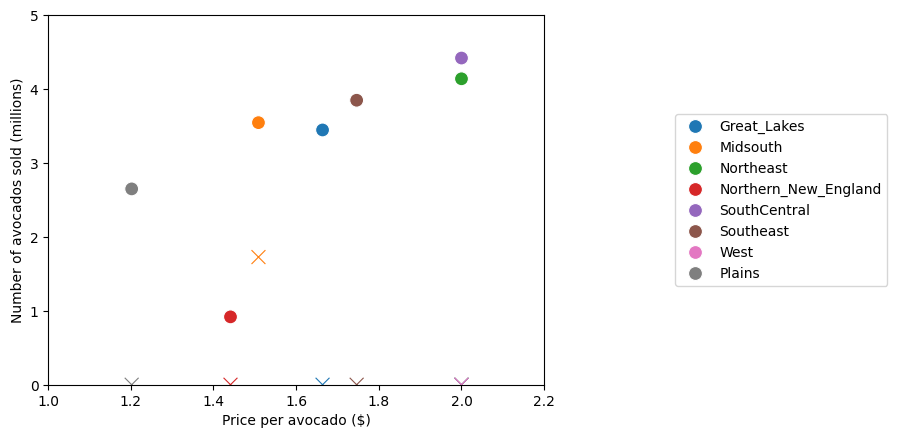

The circles represent sales quantity and the cross markers represent the wasted quantity.


In [24]:
fig, ax = plt.subplots(1,1) 
plot_sol = sns.scatterplot(data=solution,x='Price',y='Sold',hue='Region',s=100)
plot_waste = sns.scatterplot(data=solution,x='Price',y='Wasted',marker='x',hue='Region',s=100,legend = False)

plot_sol.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plot_waste.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.ylim(0, 5)
plt.xlim(1, 2.2)
ax.set_xlabel('Price per avocado ($)')
ax.set_ylabel('Number of avocados sold (millions)')
plt.show() 
print("The circles represent sales quantity and the cross markers represent the wasted quantity.")

## 实验参数设置

虽然这个笔记本逐步讲解了如何构建优化模型,但以下代码包含了整体优化模型。你可以输入不同的参数值,看看最优解如何变化。
$B$的值可以通过单元格下方的滑块进行控制。


In [26]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets 
 
import plotly.express as px

peak_or_not = 1 # 
year = 2021

# Sets and parameters
R = regions  
c_waste = 0.1 
c_transport = {'Great_Lakes': .3,'Midsouth':.1,'Northeast':.4,'Northern_New_England':.5,'SouthCentral':.3,'Southeast':.2,'West':.2,'Plains':.2}

# 从数据集中获取价格(p)和库存数量(x)的下界和上界
price_min = dict(df.groupby('region')['price'].min())
price_max = dict(df.groupby('region')['price'].max())
sold_min = dict(df.groupby('region')['units_sold'].min()) 
sold_max = dict(df.groupby('region')['units_sold'].max())   



def solve_MIQP(x):
    B = x
    
    # Initialize Model
    m = gp.Model("Avocado_Price_Allocation")

    # Variables. Adjust the bounds here 
    x = m.addVars(R,name="x",lb=sold_min,ub=sold_max) 
    p = m.addVars(R,name="p",lb=0, ub=2)   
    s = m.addVars(R,name="s",lb=0)  
    w = m.addVars(R,name="w",lb=0) 
    i = m.addVars(R,name="i",vtype=GRB.BINARY) 

    # Predictor expression for demand
    d = {r: (coef_dict['Intercept']+coef_dict['price']*p[r] + coef_dict['C(region)[T.%s]'%r] + coef_dict['year_index']*(year-2015) + coef_dict['peak']*peak_or_not) for r in R}
 
    
    # Set the objective
    m.ModelSense = GRB.MAXIMIZE
    m.setObjective(sum(p[r]*s[r] - c_waste*w[r] - c_transport[r]*x[r] for r in R)) 

    # Add the constraints 
    m.addConstrs((s[r] <= x[r] for r in R))
    m.addConstrs((s[r] <= d[r] for r in R)) 
    m.addConstrs((x[r] == w[r]+s[r] for r in R))
    m.addConstr(sum(x[r] for r in R) == B)

    # Solve   
    m.setParam('OutputFlag', 0)
    m.Params.NonConvex = 2
    m.update()
    m.optimize() 
    if m.status == 4:
        print('The problem is infeasible. Try changing the parameter values.')
    else:
        global solution, opt_revenue
        solution = pd.DataFrame() 
        solution['Region'] = R
        solution['Price'] = [p[r].X for r in R]
        solution['Allocated'] = [round(x[r].X,8) for r in R]
        solution['Sold'] = [round(s[r].X,8) for r in R]
        solution['Wasted'] = [round(w[r].X,8) for r in R]  
        solution['Demand'] = [(coef_dict['Intercept']+coef_dict['price']*p[r].X + coef_dict['C(region)[T.%s]'%r] + coef_dict['year_index']*(year-2015) + coef_dict['peak']*peak_or_not) for r in R]

        opt_revenue = m.ObjVal
        if display_figures:
            print("\n Net revenue: $%f million"%opt_revenue)
            print("\nThe optimal solution is as follows. Price per avocado in dollars. Allocated avocados, wasted avocados, and predicted demand in millions.\n")
            print(solution)
            
            print("\n Scatter plot of price vs number of avocados sold (millions) for the eight regions:")
            fig, ax = plt.subplots(1,1) 
            plot_sol = sns.scatterplot(data=solution,x='Price',y='Sold',hue='Region',s=100)
            plot_waste = sns.scatterplot(data=solution,x='Price',y='Wasted',marker='x',hue='Region',s=100,legend = False)

            plot_sol.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
            plot_waste.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
            plt.ylim(0, 5)
            plt.xlim(1, 2.2)
            ax.set_xlabel('Price per avocado ($)')
            ax.set_ylabel('Number of avocados sold (millions)')
            plt.show() 
            print("The circles represent sales quantity and the cross markers represent the wasted quantity.")
            
            
        return m.ObjVal, solution
        
        
display_figures = 1
print("Select a value for the available inventory (B) (in millions):\n")
interact(solve_MIQP, x=(15,40,1))



Select a value for the available inventory (B) (in millions):



interactive(children=(IntSlider(value=27, description='x', max=40, min=15), Output()), _dom_classes=('widget-i…

<function __main__.solve_MIQP(x)>

**观察**:
- 当供应量非常有限时,即$B$非常小时,模型设定高价格=>需求低=>分配量正好满足需求
- 随着供应量增加=>价格下降=>需求上升=>分配量可以继续满足需求
- 当供应量非常大时,浪费开始增加
 

## 比较最优与实际净收入

最后,我们可以对每年的每周运行优化模型,并比较最优预测收入与实际每周收入。
假设实际每周数量中没有浪费成本,因为这些信息是未知的。

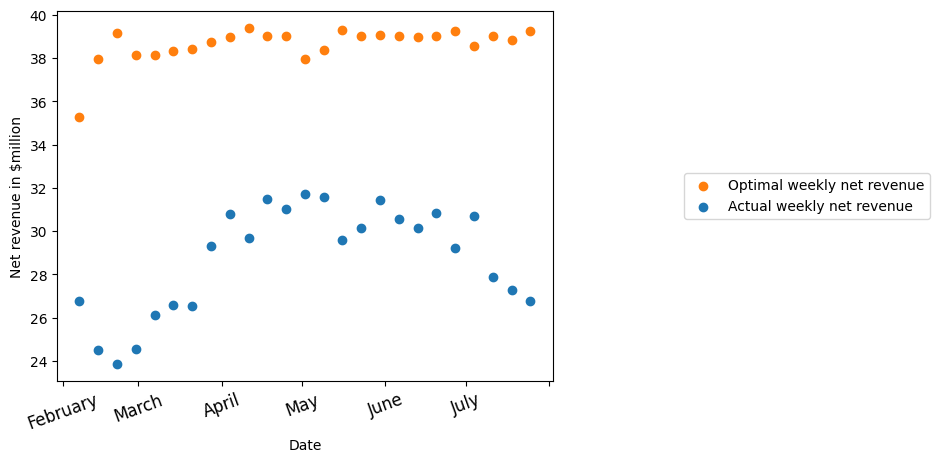

For the average peak season week in 2021, the optimal solution yields 35.288636 % more net revenue than the actual supply chain.


In [27]:
# 创建给定年份和季节的数据子集
df_subset = df[(df['year']==year) & (df['peak']==peak_or_not)]
df_subset['price_minus_transport'] = df_subset['price'] - df_subset['region'].map(c_transport) 
dates = sorted(list(set(df_subset.date))) 

# 每周运行优化器
actual, optimal, display_figures = [], [], 0
for date in dates: 
    df_date = df_subset[df_subset['date']==date] 
    weekly_sold = (df_date['units_sold']).values.sum()  
    optimal.append(solve_MIQP(weekly_sold)[0]) 
    
    actual_weekly_revenue = (df_date['units_sold']*(df_date['price_minus_transport'])).values.sum() 
    actual.append(actual_weekly_revenue) 

# 绘制两个散点图
fig_comparison, ax_comparison = plt.subplots(1,1) 
actual_plot = plt.scatter(dates, actual)
optimal_plot = plt.scatter(dates, optimal)
plt.legend((optimal_plot,actual_plot),('Optimal weekly net revenue','Actual weekly net revenue'),loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
x_ticks_labels = list(dict.fromkeys([date.strftime("%B") for date in  dates])) 
ax_comparison.set_xticklabels(x_ticks_labels, rotation=20, fontsize=12)
ax_comparison.set_xlabel('Date')
ax_comparison.set_ylabel('Net revenue in $million')

plt.show()

difference = [(i - j)/j for i, j in zip(optimal, actual)]
print("For the average peak season week in %i, the optimal solution yields %f %% more net revenue than the actual supply chain."%(year,100*sum(difference)/len(difference)))


现在,我们可以比较每周的最优解和实际数据的价格和销售情况。使用交互工具选择一个星期,看看差异。

In [28]:
def compare_with_actual(x):
    df_date = df_subset[df_subset['date']==x]
    weekly_sold = (df_date['units_sold']).values.sum()  
    print(weekly_sold)
    opt_revenue, opt_solution = solve_MIQP(weekly_sold) 

    df_comparison = df_date.merge(opt_solution, left_on='region', right_on='Region')

    df_comparison = df_comparison[['Region','price','Price','units_sold','Sold']]
    df_comparison = df_comparison.rename({'price': 'Actual price', 'Price': 'Optimal price','units_sold': 'Actual sold', 'Sold': 'Optimal sold'}, axis=1)
    print(df_comparison.sort_values(by='Region').reset_index(drop=True))

display_figures = 0
print("Select a value for the available inventory (B) (in millions):\n")
interact(compare_with_actual, x=dates)


Select a value for the available inventory (B) (in millions):



interactive(children=(Dropdown(description='x', options=(Timestamp('2021-02-07 00:00:00'), Timestamp('2021-02-…

<function __main__.compare_with_actual(x)>

注意,在某些星期和某些地区,如果优化器预见到即使需求下降也是值得的,它会设定比实际价格更高的价格。在某些其他情况下,较低的价格是首选。总体而言,最优解比实际情况多出约35%的净收入。
此分析表明,优化牛油果的定价和供应可以提高牛油果供应链的效率。

有了正确的优化工具,每一天都可以是比赛日。

In [29]:
gp.disposeDefaultEnv()

Freeing default Gurobi environment


Copyright © 2022 Gurobi Optimization, LLC